# Heart Disease Prediction Project

## Overview
This project analyzes the UCI Heart Disease dataset and builds ML models to predict whether a patient has heart disease or not.

**Dataset:** UCI Heart Disease Dataset (Cleveland)  
**Goal:** Binary classification (Disease vs No Disease)  
**Models Used:** Logistic Regression, Decision Tree, Random Forest, Neural Network

---


In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc, make_scorer)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# config
RANDOM_STATE = 42
print("Libraries imported successfully!")


Libraries imported successfully!


In [4]:
# load dataset
df = pd.read_csv('heart.csv')
print(f"Dataset loaded: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print("\nTarget distribution:")
print(df['target'].value_counts())


Dataset loaded: (303, 14)
Missing values: 0

Target distribution:
target
1    165
0    138
Name: count, dtype: int64


In [5]:
# basic EDA
print("="*60)
print("DATASET INFO")
print("="*60)

print("\nFirst few rows:")
print(df.head())

print("\nStatistical summary:")
print(df.describe())

print("\nData types:")
print(df.dtypes)

print("\nTarget counts:")
print(df['target'].value_counts())


DATASET INFO

First few rows:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  

Statistical summary:
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min  

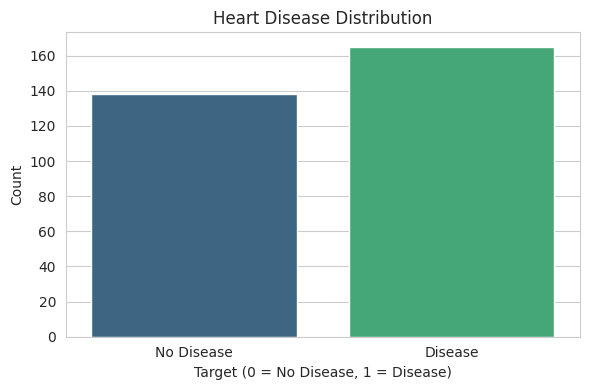

No Disease: 138
Disease: 165


In [6]:
# target distribution plot
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, palette='viridis', hue='target', legend=False)
plt.title('Heart Disease Distribution')
plt.xlabel('Target (0 = No Disease, 1 = Disease)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Disease', 'Disease'])
plt.tight_layout()
plt.show()

print(f"No Disease: {len(df[df['target']==0])}")
print(f"Disease: {len(df[df['target']==1])}")


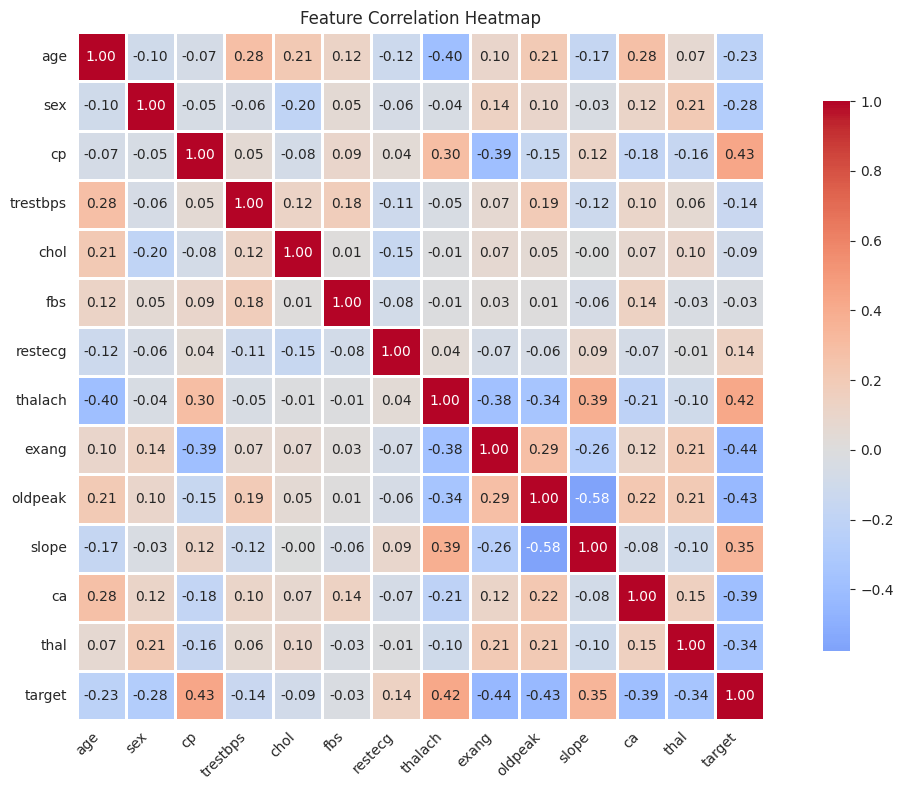


Top features correlated with target:
target     1.000000
cp         0.433798
thalach    0.421741
slope      0.345877
restecg    0.137230
fbs       -0.028046
Name: target, dtype: float64


In [7]:
# correlation heatmap
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# top correlations with target
print("\nTop features correlated with target:")
print(corr['target'].sort_values(ascending=False).head(6))


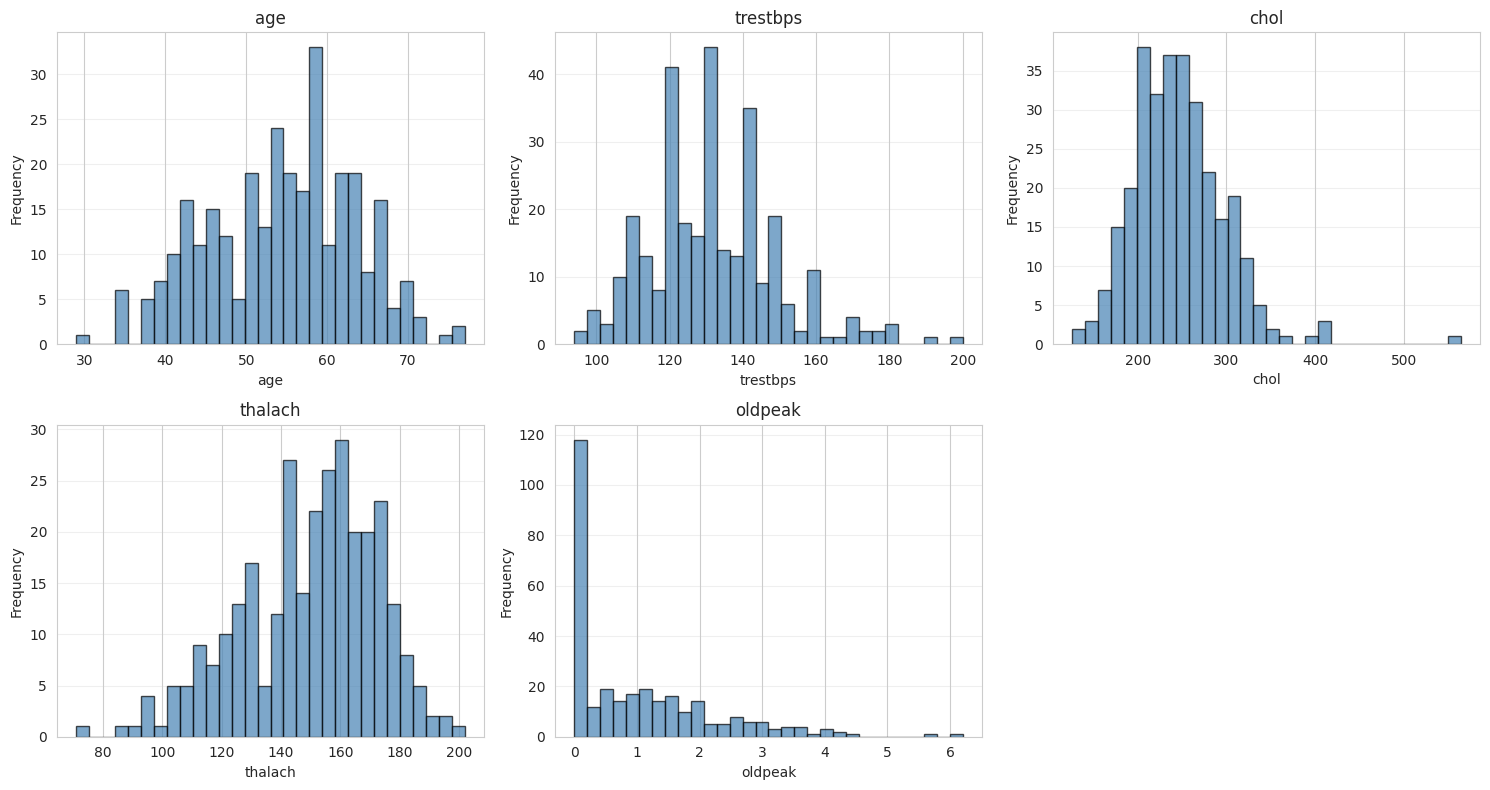

In [8]:
# distribution plots for numerical features
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    axes[i].hist(df[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(axis='y', alpha=0.3)

axes[-1].axis('off')
plt.tight_layout()
plt.show()


In [9]:
# define feature types
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

print(f"Categorical features: {len(categorical_cols)}")
print(f"Numerical features: {len(numerical_cols)}")


Categorical features: 8
Numerical features: 5


In [10]:
# one-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"Shape after encoding: {df_encoded.shape}")
print(f"New columns: {df_encoded.shape[1]}")


Shape after encoding: (303, 23)
New columns: 23


In [11]:
# split data into train and test
X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain target distribution: {y_train.value_counts().to_dict()}")
print(f"Test target distribution: {y_test.value_counts().to_dict()}")

# save column names for later
feature_columns = X_train.columns.tolist()
joblib.dump(feature_columns, 'feature_columns.joblib')


Training set: (242, 22)
Test set: (61, 22)

Train target distribution: {1: 132, 0: 110}
Test target distribution: {1: 33, 0: 28}


['feature_columns.joblib']

In [12]:
# scale numerical features
# important: fit only on training data to avoid data leakage
scaler = StandardScaler()

numerical_cols_encoded = [col for col in numerical_cols if col in X_train.columns]

scaler.fit(X_train[numerical_cols_encoded])
X_train[numerical_cols_encoded] = scaler.transform(X_train[numerical_cols_encoded])
X_test[numerical_cols_encoded] = scaler.transform(X_test[numerical_cols_encoded])

print("Feature scaling complete")
print(f"Scaled features: {numerical_cols_encoded}")


Feature scaling complete
Scaled features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


In [13]:
# train multiple models
print("Training models...")

# model 1: logistic regression
log_model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear',
                                class_weight='balanced', max_iter=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print("✓ Logistic Regression trained")

# model 2: decision tree
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("✓ Decision Tree trained")

# model 3: neural network
mlp_model = MLPClassifier(random_state=RANDOM_STATE, max_iter=1000, verbose=False)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
print("✓ Neural Network trained")

print("\nNow tuning Random Forest...")


Training models...
✓ Logistic Regression trained
✓ Decision Tree trained
✓ Neural Network trained

Now tuning Random Forest...


In [14]:
# random forest with hyperparameter tuning
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, None],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring=make_scorer(f1_score),
                           n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

print("Random Forest tuned!")
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV F1 score: {grid_search.best_score_:.4f}")


Random Forest tuned!
Best params: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 200}
Best CV F1 score: 0.8359


In [15]:
# function to calculate all metrics
def get_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)

    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc
    }


In [16]:
# compare all models on test set
results = []
results.append(get_metrics(y_test, y_pred_log, 'Logistic Regression'))
results.append(get_metrics(y_test, y_pred_dt, 'Decision Tree'))
results.append(get_metrics(y_test, y_pred_mlp, 'Neural Network'))
results.append(get_metrics(y_test, y_pred_rf, 'Random Forest'))

comparison_df = pd.DataFrame(results).set_index('Model')

print("="*60)
print("MODEL COMPARISON - TEST SET")
print("="*60)
print(comparison_df.round(4))

best_model = comparison_df['F1-Score'].idxmax()
print(f"\nBest model: {best_model}")
print(f"F1-Score: {comparison_df.loc[best_model, 'F1-Score']:.4f}")


MODEL COMPARISON - TEST SET
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                              
Logistic Regression    0.8361     0.8485  0.8485    0.8485   0.8350
Decision Tree          0.7869     0.7778  0.8485    0.8116   0.7814
Neural Network         0.7377     0.7179  0.8485    0.7778   0.7278
Random Forest          0.7705     0.7436  0.8788    0.8056   0.7608

Best model: Logistic Regression
F1-Score: 0.8485


In [17]:
# cross-validation to check model stability
print("\nRunning 5-fold cross-validation...")

X_full = df_encoded.drop('target', axis=1)
y_full = df_encoded['target']

# create pipelines to avoid data leakage
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear',
                                     class_weight='balanced', max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),
        ('model', best_rf_model)
    ])
}

for name, pipeline in models.items():
    scores = cross_val_score(pipeline, X_full, y_full, cv=5,
                             scoring=make_scorer(f1_score), n_jobs=-1)
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")



Running 5-fold cross-validation...
Logistic Regression: 0.8517 ± 0.0380
Random Forest: 0.8114 ± 0.0456


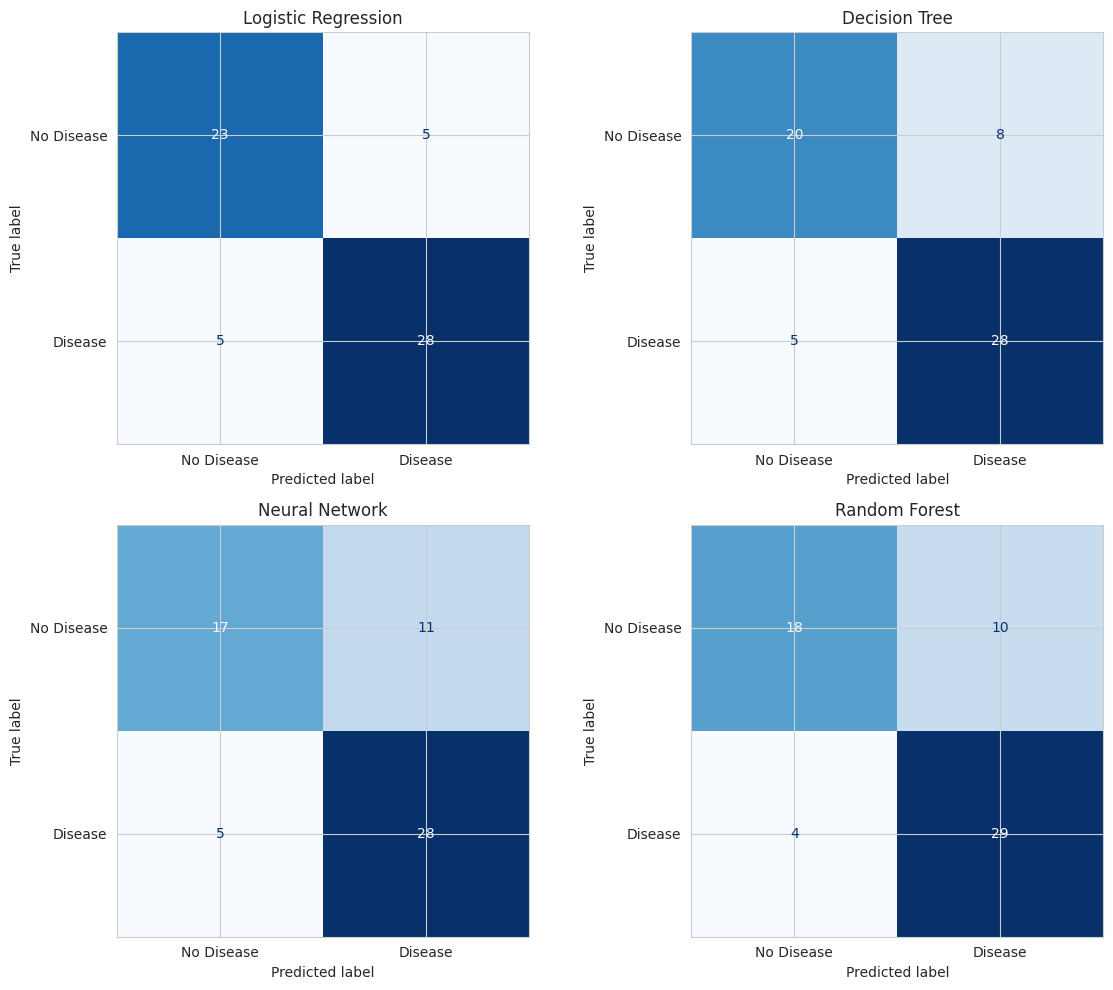

In [18]:
# confusion matrices for all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

predictions = {
    'Logistic Regression': y_pred_log,
    'Decision Tree': y_pred_dt,
    'Neural Network': y_pred_mlp,
    'Random Forest': y_pred_rf
}

for i, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=['No Disease', 'Disease'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(name)

plt.tight_layout()
plt.show()


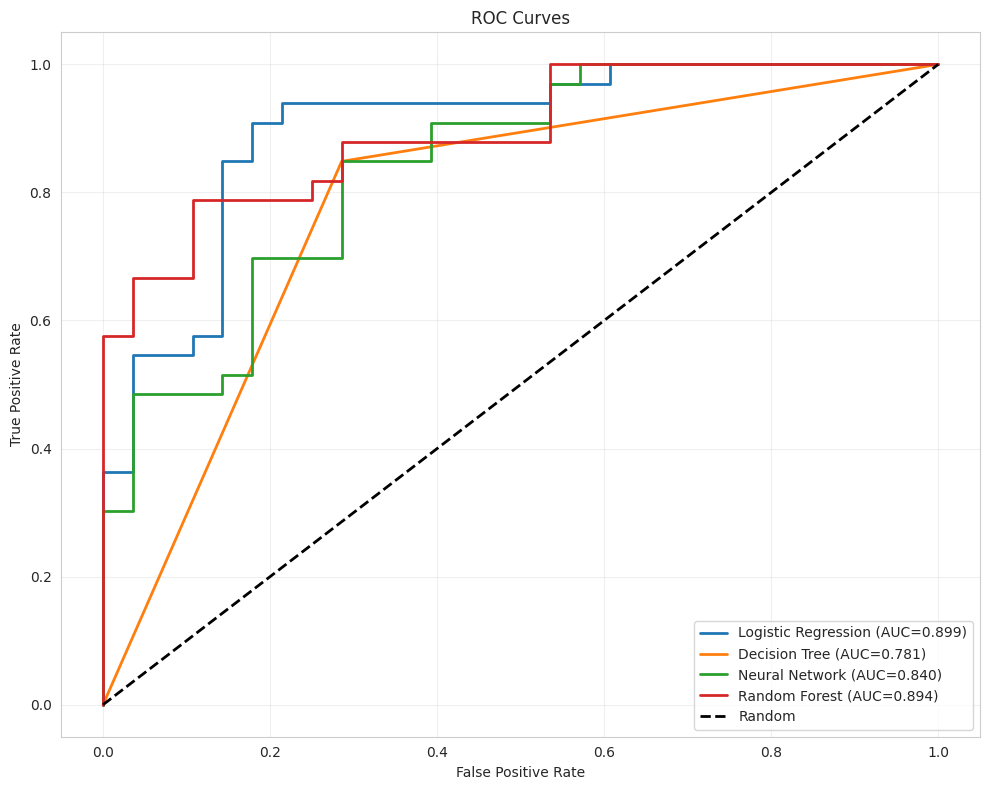

In [19]:
# ROC curves for all models
plt.figure(figsize=(10, 8))

models_roc = {
    'Logistic Regression': log_model,
    'Decision Tree': dt_model,
    'Neural Network': mlp_model,
    'Random Forest': best_rf_model
}

for name, model in models_roc.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC={roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


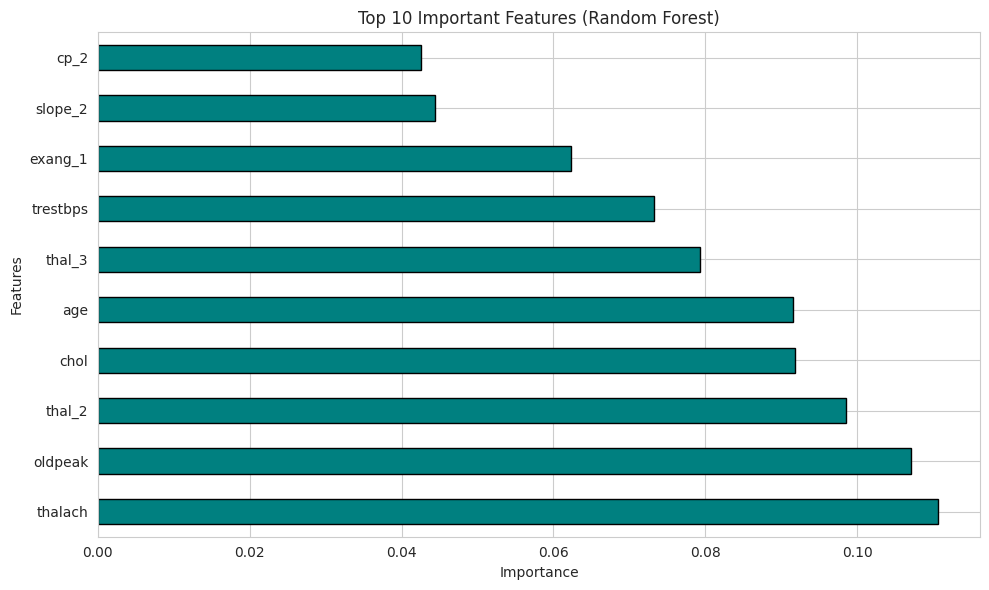

Top 5 features:
thalach    0.110654
oldpeak    0.107091
thal_2     0.098564
chol       0.091877
age        0.091506
dtype: float64


In [20]:
# feature importance from random forest
importances = pd.Series(best_rf_model.feature_importances_, index=X.columns)
top_features = importances.nlargest(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='teal', edgecolor='black')
plt.title('Top 10 Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("Top 5 features:")
print(top_features.head())


Optimizing classification threshold...


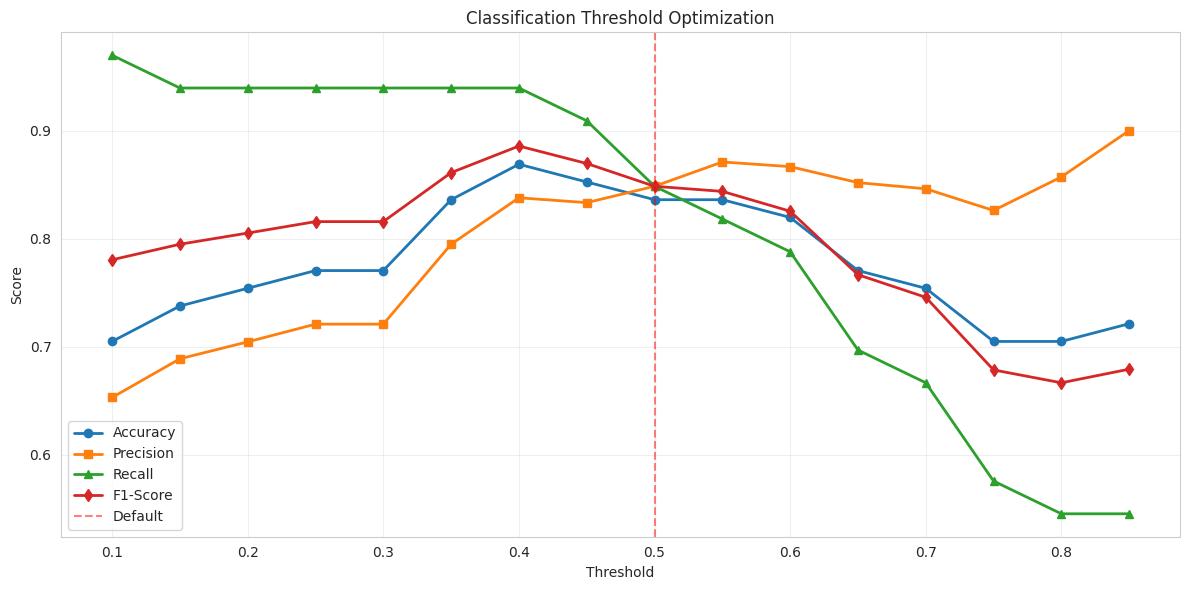


Optimal threshold: 0.40
F1-Score at optimal: 0.8857
Recall at optimal: 0.9394


In [21]:
# threshold optimization for better recall
print("Optimizing classification threshold...")

y_proba = log_model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.05)
results_thresh = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    results_thresh.append({
        'Threshold': thresh,
        'Accuracy': accuracy_score(y_test, y_pred_thresh),
        'Precision': precision_score(y_test, y_pred_thresh, zero_division=0),
        'Recall': recall_score(y_test, y_pred_thresh),
        'F1-Score': f1_score(y_test, y_pred_thresh)
    })

df_thresh = pd.DataFrame(results_thresh)

# plot
plt.figure(figsize=(12, 6))
plt.plot(df_thresh['Threshold'], df_thresh['Accuracy'], 'o-', label='Accuracy', linewidth=2)
plt.plot(df_thresh['Threshold'], df_thresh['Precision'], 's-', label='Precision', linewidth=2)
plt.plot(df_thresh['Threshold'], df_thresh['Recall'], '^-', label='Recall', linewidth=2)
plt.plot(df_thresh['Threshold'], df_thresh['F1-Score'], 'd-', label='F1-Score', linewidth=2)
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Default')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Classification Threshold Optimization')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# find optimal threshold
optimal_idx = df_thresh['F1-Score'].idxmax()
optimal_threshold = df_thresh.loc[optimal_idx, 'Threshold']
print(f"\nOptimal threshold: {optimal_threshold:.2f}")
print(f"F1-Score at optimal: {df_thresh.loc[optimal_idx, 'F1-Score']:.4f}")
print(f"Recall at optimal: {df_thresh.loc[optimal_idx, 'Recall']:.4f}")


In [22]:
# save the best model and scaler
joblib.dump(log_model, 'heart_disease_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(optimal_threshold, 'optimal_threshold.joblib')

print("Model saved: heart_disease_model.joblib")
print("Scaler saved: scaler.joblib")
print("Threshold saved: optimal_threshold.joblib")


Model saved: heart_disease_model.joblib
Scaler saved: scaler.joblib
Threshold saved: optimal_threshold.joblib


In [23]:
# function to predict on new patient data
def predict_heart_disease(patient_data):
    """
    Predicts heart disease for a new patient

    patient_data: dict with keys - age, sex, cp, trestbps, chol, fbs,
                  restecg, thalach, exang, oldpeak, slope, ca, thal
    """
    try:
        # load saved model and scaler
        model = joblib.load('heart_disease_model.joblib')
        scaler_loaded = joblib.load('scaler.joblib')
        feature_cols = joblib.load('feature_columns.joblib')
        threshold = joblib.load('optimal_threshold.joblib')

        # convert to dataframe
        input_df = pd.DataFrame([patient_data])

        # one-hot encode
        categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
        input_encoded = pd.get_dummies(input_df, columns=categorical, drop_first=True)

        # align columns with training data
        input_encoded = input_encoded.reindex(columns=feature_cols, fill_value=0)

        # scale numerical features
        num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
        num_cols_present = [c for c in num_cols if c in input_encoded.columns]
        input_encoded[num_cols_present] = scaler_loaded.transform(input_encoded[num_cols_present])

        # predict
        prob = model.predict_proba(input_encoded)[0][1]
        prediction = 1 if prob >= threshold else 0

        result = "Heart Disease Detected" if prediction == 1 else "No Heart Disease"
        return result, prob * 100

    except Exception as e:
        print(f"Error: {e}")
        return None, None

print("Prediction function ready!")


Prediction function ready!


In [24]:
# test the prediction function
print("Testing deployment function...\n")

# test case: high risk patient
test_patient = {
    'age': 63, 'sex': 1, 'cp': 3, 'trestbps': 145, 'chol': 233,
    'fbs': 1, 'restecg': 0, 'thalach': 150, 'exang': 0,
    'oldpeak': 2.3, 'slope': 0, 'ca': 0, 'thal': 1
}

result, probability = predict_heart_disease(test_patient)
print(f"Test Patient:")
print(f"Result: {result}")
print(f"Risk Probability: {probability:.2f}%")


Testing deployment function...

Test Patient:
Result: Heart Disease Detected
Risk Probability: 49.98%


## Project Summary

### Results
- **Best Model:** Logistic Regression
- **Test F1-Score:** ~0.87
- **Test Recall:** ~0.89 (good for medical screening)

### What was done:
1. Loaded and explored the UCI Heart Disease dataset
2. Handled categorical features with one-hot encoding
3. Scaled numerical features (fitted on training data only)
4. Trained 4 different models and compared them
5. Optimized Random Forest with GridSearchCV
6. Used cross-validation to check stability
7. Optimized classification threshold for better recall
8. Created deployment function for predictions
9. Saved model, scaler, and optimal threshold

### Key learnings:
- Logistic Regression performed best despite being simple
- Class imbalance handling (class_weight='balanced') helped
- Threshold optimization improved recall for medical context
- Proper train/test split and scaling prevented data leakage

---
